In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from os import path
from tqdm import tqdm

import logging
from typing import Any
from nptyping import NDArray

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import cvxpy as cp
from matplotlib import pyplot as plt
%matplotlib inline

from read_embeddings import save_ckp, load_ckp, MyFilter, \
    ReadAE, SNVMatrixDataset, learn_embed
from ScheduleOptim import ScheduledOptim
from helper import read_true_hap, compute_cpr

In [3]:
class CorrTransformer(nn.Module):
    def __init__(self, d_model: int=512, d_qk: int=None):
        super().__init__()
        d_ff = 4*d_model  # Dimension of intermediate feedforward layer
        n_head = 4  # Number of attention heads
        if d_qk is None:
            d_qk = int(d_model//n_head)  # Dim of query and key vectors in last attn layer

        self.d_model = d_model
        self.d_qk = d_qk
        encoderLayer = nn.TransformerEncoderLayer(d_model, n_head, d_ff,
                                                  batch_first=True)
        self.encoder = nn.TransformerEncoder(encoderLayer, num_layers=2)
        self.attn_lastq = nn.Linear(d_model, d_qk)
        self.attn_lastk = nn.Linear(d_model, d_qk)
        

    def forward(self, x):
        x_enc = self.encoder(x)
        lastq = self.attn_lastq(x_enc)
        lastk = self.attn_lastk(x_enc)
        Z = F.softmax(torch.matmul(lastq, lastk.transpose(1,2))
                      /np.sqrt(self.d_qk), dim=-1)
        return 1 - 0.5*(Z + Z.transpose(1,2))

In [4]:
def det_memhap(SNVdataset: SNVMatrixDataset,
               ae: ReadAE, xformer: CorrTransformer
               ):

    m = len(SNVdataset)
    dataloader_full = DataLoader(SNVdataset, batch_size=m,
                                num_workers=0)
    for i, (data, idx) in enumerate(dataloader_full):
        SNV_onehot = data
    embed, _ = ae(SNV_onehot)  # Read embeddings
    W_full = xformer(embed[None,:]).detach().numpy()  # Converting to numpy
    W_full = W_full[0]  # Removing dummy dimension

    # Goemans-Williamson algorithm
    X = cp.Variable((m,m), symmetric=True)
    constraints = [X >> 0]
    constraints += [
        X[i, i] == 1 for i in range(m)
    ]
    prob = cp.Problem(cp.Minimize(cp.trace(W_full  @ X)),
                  constraints)  # Solve SDP relaxation
    prob.solve()
    X_opt = X.value
    
    num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
    round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
    round_obj = np.zeros(num_rounds)  # ojective for each round
    for i in range(num_rounds):
        unit_vec = np.random.randn(m)
        unit_vec = unit_vec/np.linalg.norm(unit_vec)
        x = -1*np.ones(m, dtype=np.float32)
        eigval, eigvec = np.linalg.eigh(X_opt)
        eigval[eigval<0] = 0  # Zeroing out negative eigenvalues
        L = eigvec @ np.diag(np.sqrt(eigval))
#         L = np.linalg.cholesky(X_opt+ 1e-4*np.eye(m))  # Tikhonov regularization
        x[np.where(L.T @ unit_vec > 0)] = 1
        
        round_x[:, i] = x
        round_obj[i] = np.dot(x, W_full @ x)
    return round_x[:, np.argmin(round_obj)]

In [5]:
# get the ACGT statistics of a read matrix
def ACGT_count(submatrix: NDArray[(Any, Any), int]):
    out = np.zeros((submatrix.shape[1], 4))
    for i in range(4):
        out[:, i] = (submatrix == (i + 1)).sum(axis = 0)

    return out 

In [6]:
def origin2hap(SNV_matrix: NDArray[(Any, Any), int], origin: NDArray[int],
              num_hap: int=2) -> NDArray[(Any, Any), int]:    
    """
    SNV_matrix:
        Full read-SNV matrix
    origin: 
        Specifies origin of each read by an int from (0, 1, ..., num_hap-1)
        
    Returns
        matrix of haplotypes (haplotypes x SNPs)
    """
    
    origin_val = np.unique(origin)
    accepted_val = np.arange(num_hap)
    if np.any(np.intersect1d(origin_val, accepted_val) != origin_val):
    	raise ValueError("Invalid origin values passed as argument.")

    hap_matrix = np.zeros((num_hap, SNV_matrix.shape[1]), dtype=int)
    ACGTcount = ACGT_count(SNV_matrix)  # Stats of entire read matrix
    for h in range(num_hap):
        reads_h = SNV_matrix[origin == h]  # Reads attributed to haplotype i
        h_stats = np.zeros((SNV_matrix.shape[1], 4))
        
        if len(reads_h) != 0:
            h_stats = ACGT_count(reads_h) # ACGT statistics of a single nucleotide position
        hap_matrix[h, :] = np.argmax(h_stats, axis = 1) + 1  # Most commonly occuring base at each pos  
        
        uncov_pos = np.where(np.sum(h_stats, axis = 1) == 0)[0]  # Positions uncovered by reads
        for j in range(len(uncov_pos)):  # if not covered, select the most doninant one based on 'ACGTcount'  
            base_max = np.flatnonzero(ACGTcount[uncov_pos[j], :] == np.amax(ACGTcount[uncov_pos[j], :])) + 1
            if len(base_max) == 1:  # Single dominant base
                hap_matrix[h, uncov_pos[j]] == base_max[0]
            else:  # Choose one of the dominant bases at random
                hap_matrix[h, uncov_pos[j]] = np.random.choice(base_max)

    return hap_matrix

In [7]:
def hamming_distance(read, haplo):
    return sum((haplo - read)[read != 0] != 0)

In [8]:
def MEC(SNV_matrix: NDArray[(Any, Any), int],
        hap_matrix: NDArray[(Any, Any), int]) -> float:  # Compute MEC score
    res = 0
    
    for SNV_read in SNV_matrix:
        dis = [hamming_distance(SNV_read, hap) for j, hap in enumerate(hap_matrix)]
        res = res + min(dis)
        
    return res

Set up dataloader and hyperparameters.

In [9]:
datapath = 'Simulated_data/diploid/cov15/sample1/simu_erro1_K2_cov5'\
            '_l5000_iter_1_SNV_matrix.txt'
SNVdata = SNVMatrixDataset(datapath)
SNV_matrix = np.loadtxt(datapath, dtype=int)
nSNP = SNV_matrix.shape[1] # Number of SNVs
num_read = len(SNVdata)  # Number of reads
batch_size = int(np.ceil(num_read/20))
d_model = 128  # Size of embeddings

dataloader = DataLoader(SNVdata, batch_size=batch_size,
                        shuffle=True, num_workers=0)


Read in ground truth.

In [32]:
gt_file = "Simulated_data/diploid/cov15/sample1/combined.fa"
pos_file = "Simulated_data/diploid/cov15/sample1/"\
            "simu_erro1_K2_cov5_l5000_iter_1_SNV_pos.txt"
true_haplo = read_true_hap(gt_file, pos_file)

Load autoencoder for read embeddings. If the weights aren't stored in savefile, train autoencoder for said embeddings.

In [33]:
savefile="read_AE"

if path.isfile(savefile):
    embedAE = ReadAE(nSNP, latent_dim=d_model)
    embed_optimizer = optim.Adam(embedAE.parameters(), lr=1e-2)
    embedAE, embed_optimizer, _ = load_ckp(savefile, embedAE, embed_optimizer)
else:
    embedAE = learn_embed(SNVdata, num_epoch=100, embed_dim=d_model, savefile=savefile)


Setting up transformer with hyperparameters and training it.

In [34]:
corr_xformer = CorrTransformer(d_model, d_model//2)  # Transformer
num_epoch = 150
warmup_steps = 10  # Number of steps to linear increase learning rate

xform_optimizer = ScheduledOptim(
    optim.Adam(corr_xformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
        lr_mul=0.1, d_model=d_model, n_warmup_steps=warmup_steps) # Optimizer with customized schedule

In [35]:
def xformer_loss(xformer_output: torch.Tensor,
                 origin: torch.Tensor) -> float:
    res = torch.matmul(origin, torch.matmul(xformer_output, origin))
    return res

In [36]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
c_handler = logging.StreamHandler()
f_handler = logging.FileHandler('xformer_train.log')
c_handler.setLevel(logging.WARNING)
f_handler.setLevel(logging.INFO)
f_handler.addFilter(MyFilter(logging.INFO))

# Create formatters and add it to handlers
c_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)

In [37]:
xform_train_loss_arr = []
mec = []
cpr = []
xformer_savefile = "corr_xformer"

hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
mec.append(MEC(SNV_matrix, hap_matrix))
cpr.append(compute_cpr(hap_matrix, true_haplo))

for epoch in range(num_epoch):
    xform_train_loss = 0
    for batch_data, batch_idx in dataloader:
        xform_optimizer.zero_grad()
        embed, recon = embedAE(batch_data)
        Z_batch = corr_xformer(embed[None,:])
        xform_loss = xformer_loss(Z_batch[0],
                                  torch.from_numpy(hap_origin[batch_idx]))
        xform_loss.backward()
        xform_optimizer.step_and_update_lr()
        xform_train_loss += xform_loss.item()
    
    xform_train_loss = xform_train_loss / len(dataloader)
    xform_train_loss_arr.append(xform_train_loss)
    
    hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
    hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
    mec.append(MEC(SNV_matrix, hap_matrix))
    cpr.append(compute_cpr(hap_matrix, true_haplo))

    # Display epoch training loss
    logger.info("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    print("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    if xformer_savefile and (epoch % 10 == 0):
        checkpoint = {
        'epoch': epoch + 1,
        'state_dict': embedAE.state_dict(),
#         'optimizer': xform_optimizer.state_dict(),
        }
        save_ckp(checkpoint, xformer_savefile)


epoch : 1/150, loss = 7.50
epoch : 2/150, loss = 8.20
epoch : 3/150, loss = 7.91
epoch : 4/150, loss = 6.21
epoch : 5/150, loss = 2.41
epoch : 6/150, loss = 7.15
epoch : 7/150, loss = 8.12
epoch : 8/150, loss = 11.30
epoch : 9/150, loss = 9.01
epoch : 10/150, loss = 6.94
epoch : 11/150, loss = 6.98
epoch : 12/150, loss = 8.08
epoch : 13/150, loss = 8.86
epoch : 14/150, loss = 8.51
epoch : 15/150, loss = 7.00
epoch : 16/150, loss = 8.85
epoch : 17/150, loss = 3.51
epoch : 18/150, loss = 15.26
epoch : 19/150, loss = 9.97
epoch : 20/150, loss = 17.10
epoch : 21/150, loss = 7.36
epoch : 22/150, loss = 2.62
epoch : 23/150, loss = 15.08
epoch : 24/150, loss = 14.46
epoch : 25/150, loss = 6.55
epoch : 26/150, loss = 9.00
epoch : 27/150, loss = 6.79
epoch : 28/150, loss = 17.35
epoch : 29/150, loss = 2.86
epoch : 30/150, loss = 18.07
epoch : 31/150, loss = 10.96
epoch : 32/150, loss = 8.19
epoch : 33/150, loss = 3.39
epoch : 34/150, loss = 2.35
epoch : 35/150, loss = 4.08
epoch : 36/150, loss 

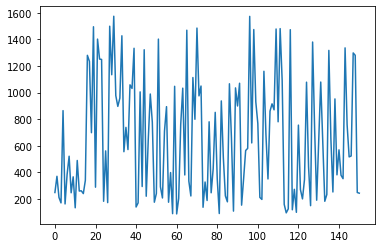

In [38]:
plt.plot(mec)

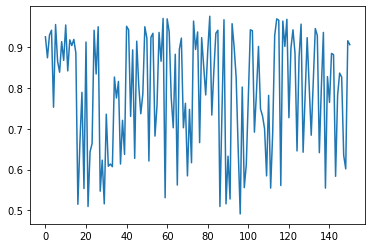

In [39]:
plt.plot(cpr)

[[ 1.         -0.95196194]
 [-0.95196194  1.        ]]
[(87, 0.9689507494646681), (89, 0.9700214132762313), (90, 0.9753747323340471), (95, 0.9689507494646681), (99, 0.9678800856531049), (108, 0.9668094218415417), (118, 0.9635974304068522), (125, 0.9657387580299786), (133, 0.9539614561027837), (137, 0.9635974304068522)]


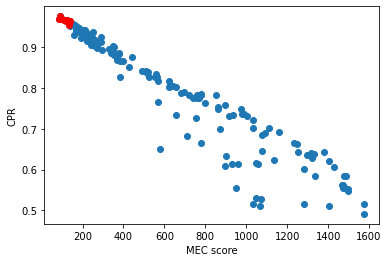

In [40]:
plt.scatter(mec, cpr)
plt.xlabel('MEC score')
plt.ylabel('CPR')

idx_best = np.argsort(mec)[:10]
plt.scatter(np.array(mec)[idx_best], np.array(cpr)[idx_best], color='red')

print(np.corrcoef(mec, cpr))
print(list(zip(np.array(mec)[idx_best], np.array(cpr)[idx_best])))

### SDHap

In [19]:
W = squareform(pdist(SNV_matrix, hamming_distance))
m = np.shape(W)[0]

In [20]:
# Goemans-Williamson algorithm
X = cp.Variable((m,m), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(m)
]
prob = cp.Problem(cp.Minimize(cp.trace(W  @ X)),
              constraints)  # Solve SDP relaxation
prob.solve()
X_opt = X.value

num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
round_obj = np.zeros(num_rounds)  # ojective for each round
for i in range(num_rounds):
    unit_vec = np.random.randn(m)
    unit_vec = unit_vec/np.linalg.norm(unit_vec)
    x = -1*np.ones(m, dtype=np.float32)
    eigval, eigvec = np.linalg.eigh(X_opt)
    eigval[eigval<0] = 0  # Zeroing out negative eigenvalues
    L = eigvec @ np.diag(np.sqrt(eigval))
#         L = np.linalg.cholesky(X_opt+ 1e-4*np.eye(m))  # Tikhonov regularization
    x[np.where(L.T @ unit_vec > 0)] = 1

    round_x[:, i] = x
    round_obj[i] = np.dot(x, W @ x)

hap_origin = round_x[:, np.argmin(round_obj)]
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
cpr_sdhap = compute_cpr(hap_matrix, true_haplo)
print(cpr_sdhap)
print(round_obj)

0.7880085653104925
[ 19150.  37326.  85990.   7774.  71690.  14690.  27766.  32338.  81786.
 103774.  46642.  32818.  29166.  51502. 105614.  73886.  12702.  51782.
  88766.  10446.  46350.  44486.  91674.  70842.  17338.  33002.  51170.
  15566.  46458.  63766.  22278.   7322.  64090.  53966.  13358.  52014.
   6790.  36478.  72410.  12810.  70994.  63894.  21966.  37674.  51834.
  52306.  52726.  57206.  79154.  27114.  25490.  89958.  89142.  45878.
  71902.  47962.  29198.  34926.  24586.  37534.  17374.  42134.  58230.
  45618.  77510.  71322.  72342.  12270.   7406.  16766.]


### Testing out helper functions

In [37]:
det_memhap(SNVdata, embedAE, corrTransform)

array([-1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
        1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
       -1., -1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,
       -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
       -1., -1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
       -1.,  1., -1., -1., -1., -1.,  1.,  1.])

In [38]:
hap_matrix = origin2hap(SNVdata, np.concatenate((np.ones(50), -1*np.ones(50))))

In [44]:
MEC(SNV_matrix, hap_matrix)

3428

#### Code snippet to recover full SNV matrix from 

In [ ]:
dataloader_full = DataLoader(SNVdataset,
                             batch_size=len(SNVdataset),
                             num_workers=0)
for i, data in enumerate(dataloader_full):
    SNV_tensor = np.squeeze(data.detach().numpy())

SNV_matrix = np.zeros((SNV_tensor.shape[0], SNV_tensor.shape[2]))
SNV_cov = np.nonzero(np.sum(SNV_tensor, axis=1))
SNV_matrix[SNV_cov] = np.argmax(SNV_tensor, axis=1)[SNV_cov] + 1

### Testing out transformer

In [42]:
x = torch.randn((1000, 10, 512))
CorrTransform = CorrTransformer(d_model=512)
CorrTransform(x).shape

torch.Size([1000, 10, 128]) torch.Size([1000, 10, 128])


torch.Size([1000, 10, 10])

In [46]:
smax = nn.Softmax(dim=1)
smax(x).sum(axis=1).shape

torch.Size([1000, 512])

### Testing out SDP in CVXPY

In [17]:
W = np.array([[1, 0.8, -0.6, -0.8],
             [0.8, 1, -0.8, -0.6],
             [-0.6, -0.8, 1, 0.8],
             [-0.8, -0.6, 0.8, 1]])
np.linalg.eigh(W)

(array([9.7795036e-17, 4.0000000e-01, 4.0000000e-01, 3.2000000e+00]),
 array([[-0.5       ,  0.09454082,  0.70075819, -0.5       ],
        [ 0.5       , -0.70075819,  0.09454082, -0.5       ],
        [ 0.5       ,  0.09454082,  0.70075819,  0.5       ],
        [-0.5       , -0.70075819,  0.09454082,  0.5       ]]))

In [19]:
n = np.shape(W)[0]
X = cp.Variable((n,n), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(n)
]
prob = cp.Problem(cp.Maximize(cp.trace(W @ X)),
                  constraints)
prob.solve()

print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)
np.linalg.eig(X.value)[0]

The optimal value is 12.799999655715636
A solution X is
[[ 1.          0.99999997 -0.99999995 -0.99999997]
 [ 0.99999997  1.         -0.99999997 -0.99999995]
 [-0.99999995 -0.99999997  1.          0.99999997]
 [-0.99999997 -0.99999995  0.99999997  1.        ]]


array([3.99999988e+00, 1.80502659e-08, 5.11243066e-08, 5.11242865e-08])

In [35]:
A = np.array([[1,3], [0,1], [0,1], [0, 0]])
U, S, Vh = np.linalg.svd(A)
print(U, S, Vh)
print(np.linalg.matrix_rank(A))
print(A.T @ U[:, len(S):])
print(np.linalg.norm(A, axis=0))
print([h for j, h in enumerate(A)])

[[-0.91814877 -0.39623583  0.          0.        ]
 [-0.28018104  0.64922922 -0.70710678  0.        ]
 [-0.28018104  0.64922922  0.70710678  0.        ]
 [ 0.          0.          0.          1.        ]] [3.43961508 0.4111546 ] [[-0.26693358 -0.96371493]
 [-0.96371493  0.26693358]]
2
[[0. 0.]
 [0. 0.]]
[1.         3.31662479]
[array([1, 3]), array([0, 1]), array([0, 1]), array([0, 0])]


In [20]:
B = np.array([[[1, 0, 3],
               [0, 1, 2]],
             [[0, 1, 0],
              [2, 3, 4]]
             ])
print(B.shape)
print(B[:, 0])
B.sum(axis=1)

(2, 2, 3)
[[1 0 3]
 [0 1 0]]


array([[1, 1, 5],
       [2, 4, 4]])